In [1]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Embeddings_UKB= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-09-11/17-17-04/Embeddings.csv")
Embeddings_HCP= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-09-11/17-17-04/hcp/Embeddings.csv")
Embeddings_epilepsy= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-09-11/17-17-04/epilepsy_PBS/Embeddings.csv")

In [3]:
Participants_epilepsy=pd.read_csv("/neurospin/dico/data/human/epilepsy_PBS/participants.tsv", sep="\t")

In [4]:
epilepsy_controls= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="controls"]
epilepsy_irm_neg= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_negatives_centrales"]
epilepsy_irm_pos= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_positives_centrales"]

In [5]:
#We rename the first colomn 

Embeddings_epilepsy  = Embeddings_epilepsy.rename(columns={Embeddings_epilepsy.columns[0]: "Index"})
Embeddings_UKB  = Embeddings_UKB.rename(columns={Embeddings_UKB.columns[0]: "Index"})

In [6]:
mask= pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/notebooks/fred/mask_interrupted_cs.csv")

In [7]:
mask=np.array(mask)

In [8]:
mask =mask.flatten()

In [9]:
Embeddings_interrupted_cs= Embeddings_UKB[mask]
Embeddings_UKB= Embeddings_UKB[~mask]

In [10]:
Embeddings_controls = Embeddings_epilepsy.merge(epilepsy_controls[["Index"]], on="Index", how="inner")
Embeddings_irm_negatives = Embeddings_epilepsy.merge(epilepsy_irm_neg[["Index"]], on="Index", how="inner")
Embeddings_irm_positives = Embeddings_epilepsy.merge(epilepsy_irm_pos[["Index"]], on="Index", how="inner")

In [11]:
X1 = Embeddings_UKB.iloc[:,1:76] #We remove de first column because it represents the id
                                 #1:76 because there are 75 components
X2= Embeddings_HCP.iloc[:,1:76]
X3= Embeddings_controls.iloc[:,1:76]
X4= Embeddings_irm_negatives.iloc[:,1:76]
X5= Embeddings_irm_positives.iloc[:,1:76]
X6= Embeddings_interrupted_cs.iloc[:,1:76]

In [13]:
X7 = X1.iloc[:len(X6), :]   # prend les premières len(X6) lignes et toutes les colonnes
X1 = X1.iloc[len(X6):, :]   # prend le reste


In [14]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2=scaler.transform(X2)
X3=scaler.transform(X3)
X4=scaler.transform(X4)
X5=scaler.transform(X5)
X6=scaler.transform(X6)
X7=scaler.transform(X7)


In [15]:
import statsmodels.api as sm

In [16]:
L= np.concatenate((X1,X2,X3,X4,X5,X6,X7), axis=0)

covariates = pd.DataFrame({
    'Site': ['UKB']*len(X1) 
            + ['hcp']*len(X2) 
            + ['epilepsy_PBS']*(len(X3)+len(X4)+len(X5)) 
            + ['UKB']*( len(X6) + len(X7))
})


In [17]:
covariates = pd.get_dummies(covariates)


In [18]:
covariates_train= pd.concat([covariates.head(len(X1)+len(X2)+len(X3)), covariates.tail(len(X6)+len(X7))], ignore_index=True)
covariates_test= covariates.iloc[len(X1)+len(X2)+len(X3):len(X1)+len(X2)+len(X3)+len(X4)+len(X5)]

L_train=np.concatenate((X1,X2,X3,X6,X7), axis=0)
L_test= np.concatenate((X4,X5), axis=0)

In [19]:
covariates = sm.add_constant(covariates)  # Add intercept

L1_resid = np.zeros_like(L_train)
L2_resid = np.zeros_like(L_test)

for j in range(L_train.shape[1]):
    model = sm.OLS(L_train[:, j].astype(float), covariates_train.astype(float)).fit()
    L1_resid[:, j] = model.resid 
    L2_resid[:, j] = L_test[:,j] - model.predict(covariates_test)


In [20]:
X_ukb = L1_resid[:len(X1),:]
X_hcp = L1_resid[len(X1):len(X1)+len(X2),:]
X_control= L1_resid[len(X1)+len(X2):len(X1)+len(X2)+len(X3),:]
X_neg= L2_resid[:len(X4),:]
X_pos=L2_resid[len(X4):,:]
X_cs=L1_resid[len(X1)+len(X2)+len(X3):,:]
X_ukb_test=L1_resid[len(X1)+len(X2)+len(X3)+len(X6):,:]


In [21]:
def proportion_positive(L):
    n_total = len(L)
    n_pos = np.sum(L == 1)

    return n_pos / n_total

One-class SVM

In [22]:
from sklearn.svm import OneClassSVM

Isolation forest

In [23]:
from sklearn.ensemble import IsolationForest

LOF

In [24]:
from sklearn.neighbors import LocalOutlierFactor

In [25]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []
prop_positive_UKB_test= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X_ukb)
    y1 = lof.predict(X_ukb)
    y2 = lof.predict(X_hcp)
    y3 = lof.predict(X_control)
    y4 = lof.predict(X_neg)
    y5 = lof.predict(X_pos)
    y6 = lof.predict(X_cs)
    y7= lof.predict(X_ukb_test)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))
    prop_positive_UKB_test.append(proportion_positive(y7))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)+np.array(prop_positive_UKB_test)


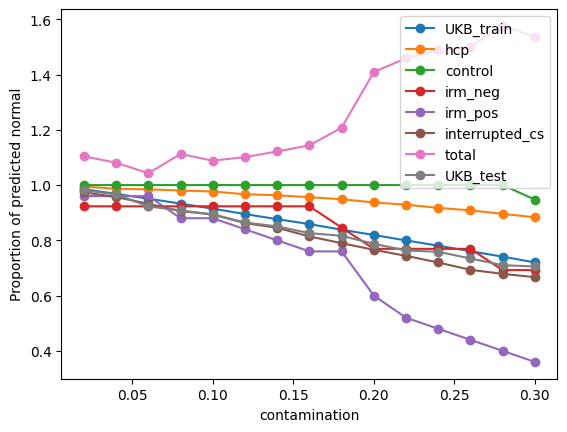

In [26]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB_train")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")
plt.plot(contamination, prop_positive_UKB_test, marker='o', linestyle='-', label="UKB_test")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

ABOD

In [27]:
from pyod.models.abod import ABOD

UMAP 2D

In [28]:
reducer = umap.UMAP(n_components=2, random_state=42)
X1_umap2 = reducer.fit_transform(X_ukb)
X2_umap2 = reducer.transform(X_hcp)
X3_umap2= reducer.transform(X_control)
X4_umap2=reducer.transform(X_neg)
X5_umap2=reducer.transform(X_pos)
X6_umap2=reducer.transform(X_cs)
X7_umap2=reducer.transform(X_ukb_test)


/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [29]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []
prop_positive_UKB_test= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap2)

    y1 = clf.predict(X1_umap2)
    y2 = clf.predict(X2_umap2)
    y3 = clf.predict(X3_umap2)
    y4 = clf.predict(X4_umap2)
    y5 = clf.predict(X5_umap2)
    y6 = clf.predict(X6_umap2)
    y7 = clf.predict(X7_umap2)


    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))
    prop_positive_UKB_test.append(proportion_positive(y7))


total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)+np.array(prop_positive_UKB_test)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


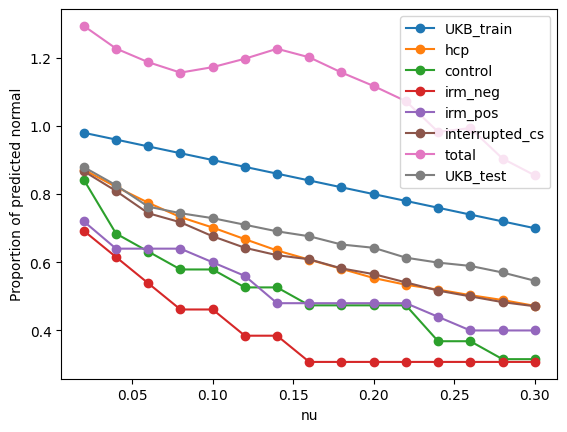

In [30]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB_train")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(nu, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(nu, total, marker='o', linestyle='-', label="total")
plt.plot(nu, prop_positive_UKB_test, marker='o', linestyle='-', label="UKB_test")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [31]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []
prop_positive_UKB_test= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap2)

    y1 = clf.predict(X1_umap2)
    y2 = clf.predict(X2_umap2)
    y3 = clf.predict(X3_umap2)
    y4 = clf.predict(X4_umap2)
    y5 = clf.predict(X5_umap2)
    y6 = clf.predict(X6_umap2)
    y7 = clf.predict(X7_umap2)


    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))
    prop_positive_UKB_test.append(proportion_positive(y7))

total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)+np.array(prop_positive_UKB_test)

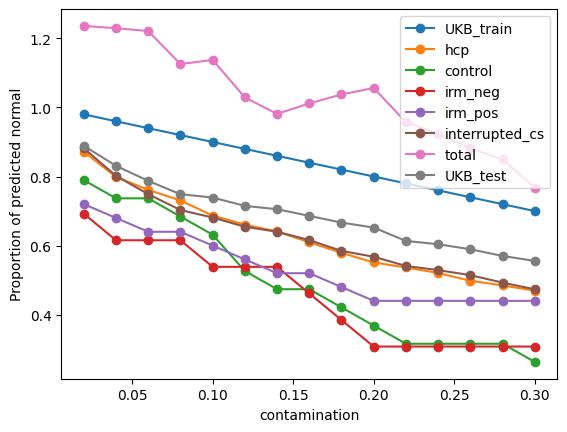

In [32]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB_train")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")
plt.plot(contamination, prop_positive_UKB_test, marker='o', linestyle='-', label="UKB_test")


plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [33]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []
prop_positive_UKB_test= []

for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1_umap2)

    y1 =1-  clf.predict(X1_umap2)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap2)
    y3 = 1- clf.predict(X3_umap2)
    y4 = 1-  clf.predict(X4_umap2)
    y5 = 1- clf.predict(X5_umap2)
    y6 = 1- clf.predict(X6_umap2)
    y7 = 1- clf.predict(X7_umap2)


    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))
    prop_positive_UKB_test.append(proportion_positive(y7))


total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)+ np.array(prop_positive_UKB_test)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


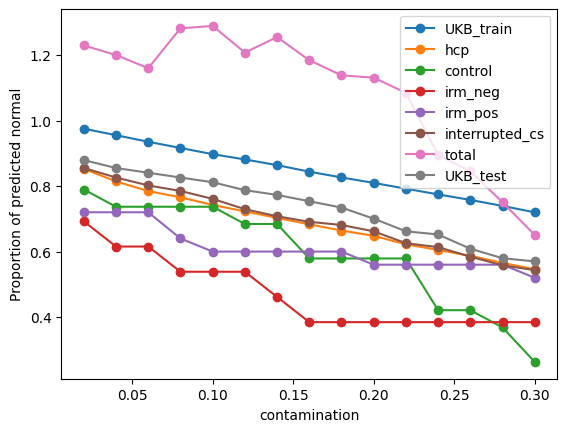

In [34]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB_train")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")
plt.plot(contamination, prop_positive_UKB_test, marker='o', linestyle='-', label="UKB_test")


plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

UMAP 30D

In [35]:
reducer = umap.UMAP(n_components=30, random_state=42)
X1_umap30 = reducer.fit_transform(X_ukb)
X2_umap30 = reducer.transform(X_hcp)
X3_umap30= reducer.transform(X_control)
X4_umap30=reducer.transform(X_neg)
X5_umap30=reducer.transform(X_pos)
X6_umap30=reducer.transform(X_cs)
X7_umap30 = reducer.transform(X_ukb_test)


/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [36]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []
prop_positive_UKB_test= []


for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1_umap30)

    y1 = 1- clf.predict(X1_umap30)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap30)
    y3 = 1- clf.predict(X3_umap30)
    y4 = 1- clf.predict(X4_umap30)
    y5 = 1- clf.predict(X5_umap30)
    y6 = 1- clf.predict(X6_umap30)
    y7 = 1- clf.predict(X7_umap30)


    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))
    prop_positive_UKB_test.append(proportion_positive(y7))


total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)+np.array(prop_positive_UKB_test)


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


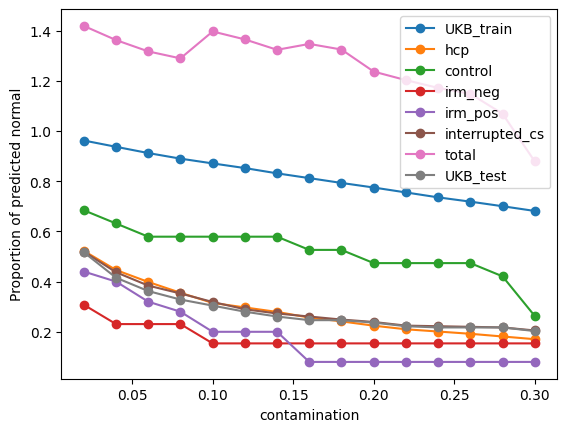

In [37]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB_train")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")
plt.plot(contamination, prop_positive_UKB_test, marker='o', linestyle='-', label="UKB_test")


plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

UMAP 40D

In [38]:
reducer = umap.UMAP(n_components=40, random_state=42)
X1_umap40 = reducer.fit_transform(X_ukb)
X2_umap40 = reducer.transform(X_hcp)
X3_umap40= reducer.transform(X_control)
X4_umap40=reducer.transform(X_neg)
X5_umap40=reducer.transform(X_pos)
X6_umap40=reducer.transform(X_cs)
X7_umap40 = reducer.transform(X_ukb_test)


/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [39]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []
prop_positive_UKB_test= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap40)

    y1 = clf.predict(X1_umap40)
    y2 = clf.predict(X2_umap40)
    y3 = clf.predict(X3_umap40)
    y4 = clf.predict(X4_umap40)
    y5 = clf.predict(X5_umap40)
    y6 = clf.predict(X6_umap40)
    y7 = clf.predict(X7_umap40)


    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))
    prop_positive_pos.append(proportion_positive(y5))
    prop_positive_interrupted_cs.append(proportion_positive(y6))
    prop_positive_UKB_test.append(proportion_positive(y7))


total = np.array(prop_positive_UKB)+np.array(prop_positive_hcp)+np.array(prop_positive_control)-np.array(prop_positive_neg)-np.array(prop_positive_pos) -np.array(prop_positive_interrupted_cs)+ np.array(prop_positive_UKB_test)

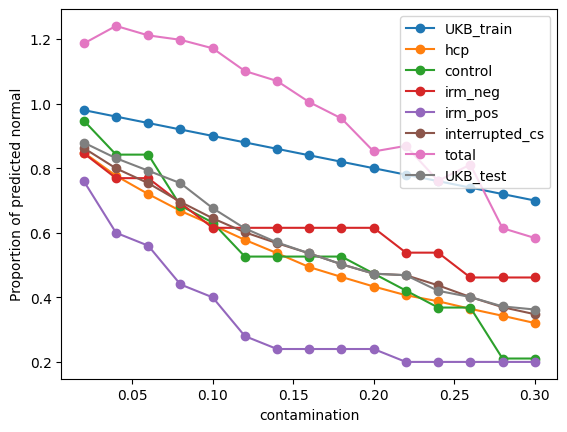

In [40]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB_train")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
plt.plot(contamination, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")
plt.plot(contamination, prop_positive_interrupted_cs, marker='o', linestyle='-', label="interrupted_cs")
plt.plot(contamination, total, marker='o', linestyle='-', label="total")
plt.plot(contamination, prop_positive_UKB_test, marker='o', linestyle='-', label="UKB_test")


plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()